In [18]:
import os
import zipfile
import cv2
import numpy as np
ZIP_FILE = "/content/audio_languages.zip"
EXTRACT_PATH = "audio_dataset"

with zipfile.ZipFile(ZIP_FILE, 'r') as zip_ref:
    zip_ref.extractall(EXTRACT_PATH)

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

dataset_path = "/content/audio_dataset/Indian_Languages_Audio_Dataset"
labels = os.listdir(dataset_path)
print(labels)

['Telugu', 'Tamil', 'Kannada', 'Punjabi', 'Bengali', 'Malayalam', 'Hindi']


eda

summary info

In [20]:
import librosa.display
audio_stats = []

#  Loop through all files
for language in os.listdir(dataset_path):
    lang_path = os.path.join(dataset_path, language)
    if not os.path.isdir(lang_path): continue

    for file in os.listdir(lang_path):
        if not file.endswith(".mp3"): continue

        file_path = os.path.join(lang_path, file)
        try:
            # 🔊 Load audio
            y, sr = librosa.load(file_path, sr=None)
            duration = librosa.get_duration(y=y, sr=sr)
            zcr = librosa.feature.zero_crossing_rate(y)[0].mean()
            energy = librosa.feature.rms(y=y)[0].mean()
            centroid = librosa.feature.spectral_centroid(y=y, sr=sr)[0].mean()

            # ➕ Save stats
            audio_stats.append({
                "file": file,
                "language": language,
                "duration_sec": duration,
                "sample_rate": sr,
                "zero_crossing_rate": zcr,
                "rms_energy": energy,
                "spectral_centroid": centroid
            })

        except Exception as e:
            print(f"Error with file {file}: {e}")

convert to data frame

In [21]:
df = pd.DataFrame(audio_stats)
print("Summary Stats:")
print(df.groupby("language")[["duration_sec", "zero_crossing_rate", "rms_energy"]].mean())



Summary Stats:
           duration_sec  zero_crossing_rate  rms_energy
language                                               
Bengali        4.982514            0.043373    0.046511
Hindi          4.988498            0.082058    0.048585
Kannada        4.985340            0.079376    0.029283
Malayalam      4.987946            0.058605    0.062950
Punjabi        4.979366            0.040750    0.085195
Tamil          4.974502            0.034558    0.173272
Telugu         4.977507            0.060775    0.071332


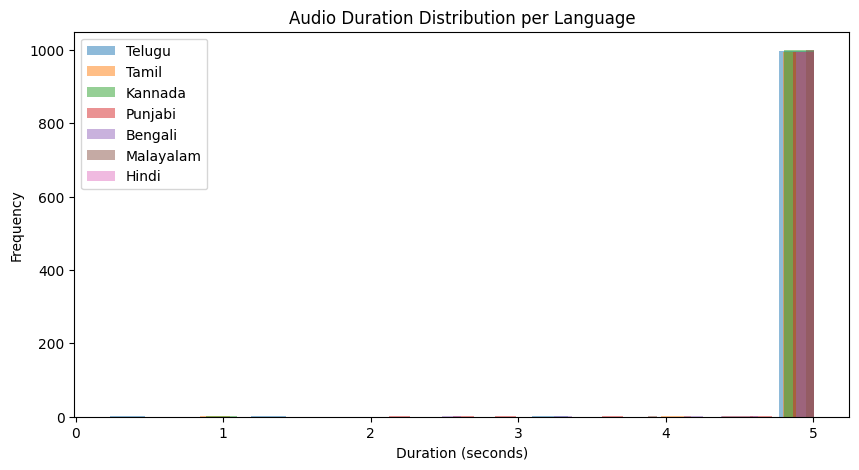

In [22]:
#  Plot duration distribution
plt.figure(figsize=(10, 5))
for lang in df['language'].unique():
    durations = df[df['language'] == lang]['duration_sec']
    plt.hist(durations, bins=20, alpha=0.5, label=lang)
plt.title("Audio Duration Distribution per Language")
plt.xlabel("Duration (seconds)")
plt.ylabel("Frequency")
plt.legend()
plt.show()

In [23]:
sample = df.sample(1).iloc[0]
sample_path = os.path.join(dataset_path, sample['language'], sample['file'])

waveform visualize

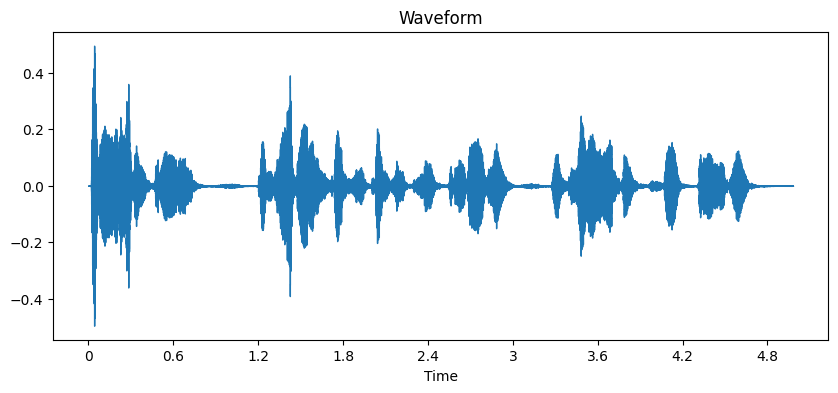

In [24]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
#hindi sample audio
audio, sr = librosa.load("/content/audio_dataset/Indian_Languages_Audio_Dataset/Hindi/10013.mp3")
plt.figure(figsize=(10, 4))
librosa.display.waveshow(audio, sr=sr)
plt.title("Waveform")
plt.show()

waveform info

In [25]:
print(f"Sample Rate: {sr}")
print(f"Audio Duration: {librosa.get_duration(y=audio, sr=sr):.2f} seconds")

Sample Rate: 22050
Audio Duration: 4.98 seconds


spectogram vizualize

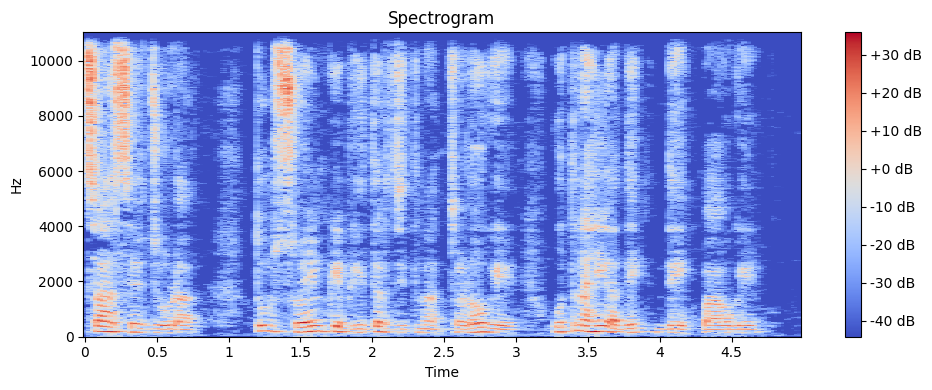

In [26]:
plt.figure(figsize=(10, 4))
spectrogram = librosa.stft(audio)
spectrogram_db = librosa.amplitude_to_db(abs(spectrogram))
librosa.display.specshow(spectrogram_db, sr=sr, x_axis='time', y_axis='hz')
plt.colorbar(format='%+2.0f dB')
plt.title("Spectrogram")
plt.tight_layout()
plt.show()

mfcc

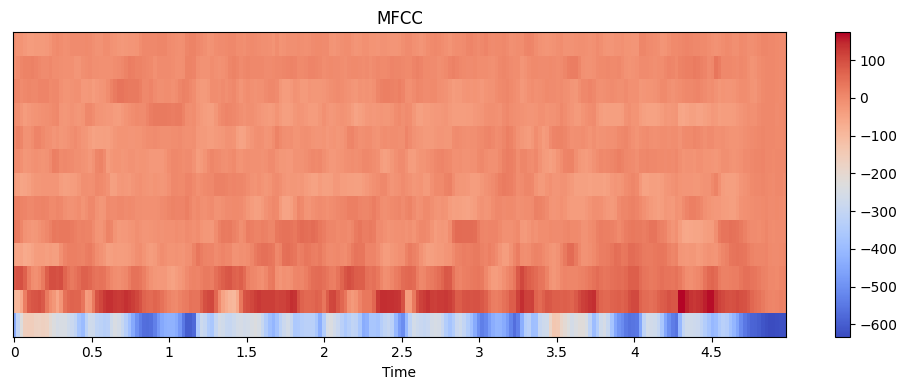

In [27]:
mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=13)
plt.figure(figsize=(10, 4))
librosa.display.specshow(mfcc, x_axis='time')
plt.colorbar()
plt.title("MFCC")
plt.tight_layout()
plt.show()

In [28]:
from IPython.display import Audio, display

display(Audio(sample_path))

feature and target

In [29]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm
X = []
y = []
label_names = []

for language in os.listdir(dataset_path):
    lang_path = os.path.join(dataset_path, language)
    if not os.path.isdir(lang_path): continue

    for file in os.listdir(lang_path):
        if not file.endswith(".mp3"): continue

        try:
            file_path = os.path.join(lang_path, file)
            audio, sr = librosa.load(file_path, sr=None)

            mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=13)
            mfccs_mean = np.mean(mfccs.T, axis=0)  # (13,)

            X.append(mfccs_mean)
            y.append(language)
        except Exception as e:
            print(f"Error in {file}: {e}")

# Encode labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)

#  Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)


random forest

Random forest Classification Report:
              precision    recall  f1-score   support

     Bengali       0.88      0.94      0.91       200
       Hindi       0.97      0.98      0.98       200
     Kannada       0.99      0.93      0.96       200
   Malayalam       0.93      0.95      0.94       200
     Punjabi       0.96      0.95      0.96       200
       Tamil       0.96      0.96      0.96       200
      Telugu       0.96      0.92      0.94       200

    accuracy                           0.95      1400
   macro avg       0.95      0.95      0.95      1400
weighted avg       0.95      0.95      0.95      1400



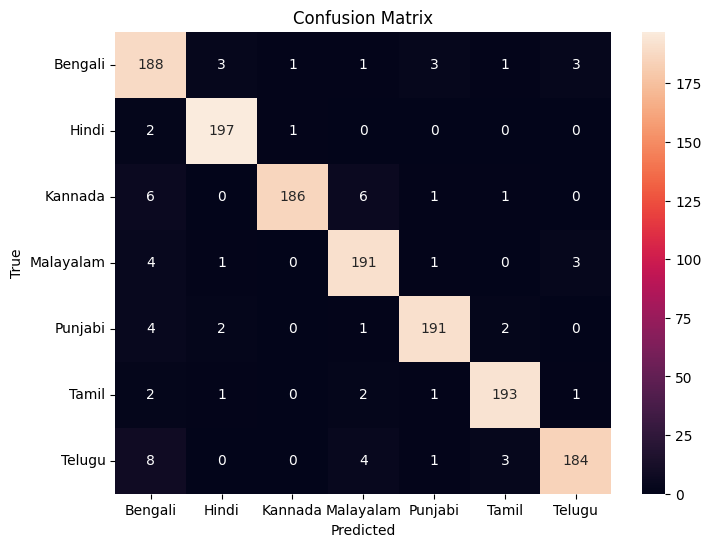

In [30]:
#  Train classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

#  Evaluate
y_pred = clf.predict(X_test)
print("Random forest Classification Report:")
print(classification_report(y_test, y_pred, target_names=le.classes_))

#  Confusion Matrix
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

svm

 SVM Classification Report:
              precision    recall  f1-score   support

     Bengali       0.77      0.82      0.79       200
       Hindi       0.88      0.91      0.90       200
     Kannada       0.97      0.91      0.94       200
   Malayalam       0.90      0.93      0.91       200
     Punjabi       0.88      0.92      0.89       200
       Tamil       0.87      0.89      0.88       200
      Telugu       0.89      0.78      0.83       200

    accuracy                           0.88      1400
   macro avg       0.88      0.88      0.88      1400
weighted avg       0.88      0.88      0.88      1400



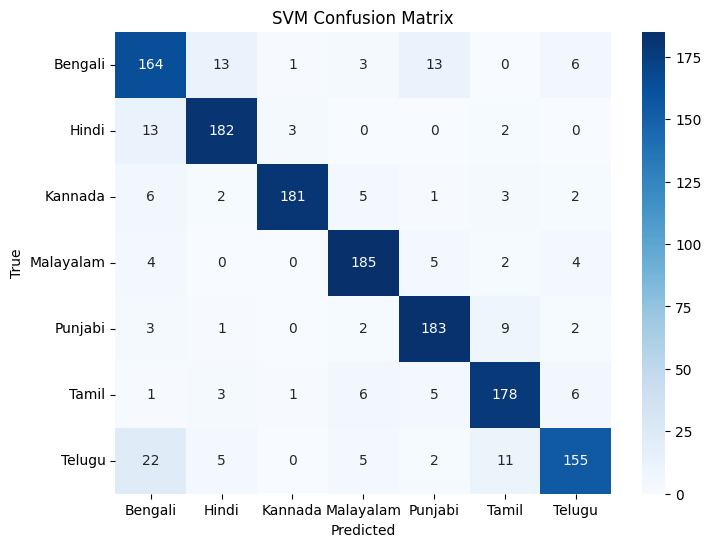

In [31]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix

#  Train SVM Classifier
svm_clf = SVC(kernel='rbf', C=10, gamma='scale')  # You can tune C and gamma
svm_clf.fit(X_train, y_train)

#  Predict
svm_pred = svm_clf.predict(X_test)

#  Evaluate
print(" SVM Classification Report:")
print(classification_report(y_test, svm_pred, target_names=le.classes_))

#  Confusion Matrix

plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, svm_pred), annot=True, fmt="d",
            xticklabels=le.classes_, yticklabels=le.classes_, cmap="Blues")
plt.title("SVM Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()
